In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src/")
#sys.path.insert(0,"../src_fork/analysis")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction


utils.plot_settings()  # LaTeX fonts in Plots!

FIGPATH = "../figs/"
FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

SEEDVAL = 2021

In [2]:
np.random.seed(SEEDVAL)
n = 500
noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
max_degree = 15
n_lambdas = 30
n_bootstraps = 200
k_folds = 5
lambdas = np.logspace(-5, 0, n_lambdas)
subset_lambdas = lambdas[::60]

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    # All regression bootstraps at once
    lamb_ridge = best_ridge_lambda[degree_index]
    lamb_lasso = best_lasso_lambda[degree_index]

    (
        ridge_mse,
        ridge_bias,
        ridge_variance,
        lasso_mse,
        lasso_bias,
        lasso_variance,
        ols_mse,
        ols_bias,
        ols_variance,
    ) = bootstrap.bootstrap_all(
        X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
    )

    (
        ridge_best_lambda_boot_mse[degree_index],
        ridge_best_lambda_boot_bias[degree_index],
        ridge_best_lambda_boot_variance[degree_index],
    ) = (ridge_mse, ridge_bias, ridge_variance)

    (
        lasso_best_lambda_boot_mse[degree_index],
        lasso_best_lambda_boot_bias[degree_index],
        lasso_best_lambda_boot_variance[degree_index],
    ) = (lasso_mse, lasso_bias, lasso_variance)

    ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
        ols_mse,
        ols_bias,
        ols_variance,
    )

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.567123074848331, tolerance: 0.004121369307289511
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.25654833941725, tolerance: 0.004429873394640893
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.267984046021605, tolerance: 0.0046649203704854925
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.987870676723368, tolerance: 0.00464544485911784
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.924735756239811, tolerance: 0.00413723211724761
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.327086587316849, tolerance: 0.0047729272328318985
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.299505701528675, tolerance: 0.004356225240985283
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.282464632475207, tolerance: 0.004831247449771435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.650706933317856, tolerance: 0.004731534455093339
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.989520405027809, tolerance: 0.0045578914568942495
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.298963533997542, tolerance: 0.004172772442377331
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.174474151525693, tolerance: 0.004275779884360936
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.643130344557483, tolerance: 0.004504085199958086
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.760740901386706, tolerance: 0.004453958425471766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.718261060960378, tolerance: 0.004416358899990536
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.3110091200823, tolerance: 0.005109544122902008
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.82172338763542, tolerance: 0.005076206808325738
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.722139001026951, tolerance: 0.00523841148788217
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.84908150569532, tolerance: 0.004477961119068051
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.662511516164383, tolerance: 0.004754608860216963
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.51772152095875, tolerance: 0.004506800052987079
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.548736870033084, tolerance: 0.0042625590681600895
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.237512328699339, tolerance: 0.004480637901002761
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.409728206367, tolerance: 0.004316990634346875
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.937811075425188, tolerance: 0.004313888589825411
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.92623021576095, tolerance: 0.004214425164294793
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.303934664580414, tolerance: 0.00444570604546228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4281374418753394, tolerance: 0.00444570604546228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.357133887617696, tolerance: 0.0045684875450748355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3844866383741827, tolerance: 0.004371532756291615
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.391976952995257, tolerance: 0.004127672187559232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.834228635190478, tolerance: 0.0043765295734859285
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.734572638945505, tolerance: 0.004493871513542919
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.34904707194091, tolerance: 0.004518230958553043
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.191661556968826, tolerance: 0.005027441452046709
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.192593374876525, tolerance: 0.0043789872673428406
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.425734470477009, tolerance: 0.004543211128177405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.741396313334644, tolerance: 0.005406268498226055
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.876218159949627, tolerance: 0.004608023167122443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.259533492020822, tolerance: 0.004848456119219465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.475133110344114, tolerance: 0.004640632895031528
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.304905578951603, tolerance: 0.004446359179052766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4732153559032444, tolerance: 0.004446359179052766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2925828404755251, tolerance: 0.004488866448953129
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05799643591545589, tolerance: 0.004194202531911705
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.098703549869947, tolerance: 0.004506025701375495
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.642319859167222, tolerance: 0.004075288298369876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.856768402131705, tolerance: 0.004244716262829104
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.900678438085599, tolerance: 0.005257705706740256
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.024054414796087, tolerance: 0.004170373351480328
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.54902760267996, tolerance: 0.004788456692812596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.72460990704764, tolerance: 0.004690516427794368
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.914724812855178, tolerance: 0.004817601962813649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.859365303859068, tolerance: 0.004663989612554415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.168258753129695, tolerance: 0.004344857495413505
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.627068784796425, tolerance: 0.004833820115488783
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.719324672410877, tolerance: 0.004215559826670096
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.262054023611102, tolerance: 0.004430935527483391
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.405823081796921, tolerance: 0.0047755027960110896
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.040611592622982, tolerance: 0.0049551133514868645
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.941345327520417, tolerance: 0.004371943591331011
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2826930442219986, tolerance: 0.004440693929807697
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.681229631833652, tolerance: 0.004422810183627136
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008057571096916405, tolerance: 0.004428041612278478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011903254258243123, tolerance: 0.004371943591331011
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004384442860327908, tolerance: 0.00425055078390461
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.168743923348877, tolerance: 0.004650003058394288
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.367105948691817, tolerance: 0.004603567619913739
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.918660717418804, tolerance: 0.00451911053993655
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.739634035259323, tolerance: 0.004712397410729555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.286523089827043, tolerance: 0.004275302200380604
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.543810652820213, tolerance: 0.004173166952454759
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.236919737387289, tolerance: 0.004353031460170114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.34549009426887, tolerance: 0.004851903143363308
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.087736458118563, tolerance: 0.0043476725495862865
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.304583091592446, tolerance: 0.004997066367412106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.712707882216253, tolerance: 0.005188394202183622
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4113791218362195, tolerance: 0.0044744012410825665
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.563561573655937, tolerance: 0.004984764857848073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.085929571921005, tolerance: 0.004402577535878554
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.64187559673892, tolerance: 0.004328101453561251
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.278681833213412, tolerance: 0.004421544853150843
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.44226821067031, tolerance: 0.004347902399669642
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.15523754883606, tolerance: 0.004335428329651789
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.561503861450289, tolerance: 0.004335428329651789
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9379108631482946, tolerance: 0.004154276307995177
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5893210527222656, tolerance: 0.004654888210481483
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6664354194161985, tolerance: 0.0042927592638049746
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.601085800914846, tolerance: 0.004882944484108225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9724528394234735, tolerance: 0.005109636735146265
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.244920199534155, tolerance: 0.003951618632885661
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.452892200667449, tolerance: 0.004793110947106319
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5881678081778166, tolerance: 0.00465159323285598
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.997848043466901, tolerance: 0.004344874319656925
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.062738470188565, tolerance: 0.0045679054059331444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.590157981442112, tolerance: 0.004815325944736391
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.779480644704499, tolerance: 0.004968548296004631
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.733042150144916, tolerance: 0.004667104133268487
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9954631216360346, tolerance: 0.0042404839222592115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.737083742111159, tolerance: 0.004441021663072252
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.337934702157458, tolerance: 0.004446826834941555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.44756778473684, tolerance: 0.00468405092100959
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7626850014645736, tolerance: 0.004482959375848872
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9227255208811407, tolerance: 0.004518445380723472
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8017687325439944, tolerance: 0.0044018438167795215
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.642312631269291, tolerance: 0.004101238749381824
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8903021879610495, tolerance: 0.00425689226205564
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.251301732769725, tolerance: 0.0049242409601995465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.103725175698815, tolerance: 0.004232742220943008
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3228555791756245, tolerance: 0.004784816809867611
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.950069783093518, tolerance: 0.004551581800696493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.815420885656215, tolerance: 0.004448497356001694
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.472953321239677, tolerance: 0.0046728755086996344
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.921136693493705, tolerance: 0.004293558952345838
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.483773613329926, tolerance: 0.004475182196072777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.728605044421753, tolerance: 0.003860733035543934
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.996283817118079, tolerance: 0.004846882158999128
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.161618052072632, tolerance: 0.00463871855249285
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.000712100842512, tolerance: 0.004577088079386641
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.216071639432087, tolerance: 0.004659614324391042
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.741580473127186, tolerance: 0.0055853399262288245
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0321011283077315, tolerance: 0.004910566151681077
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.739929364528805, tolerance: 0.004649630696733986
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.06086273012846, tolerance: 0.0044754940601502355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.4141927172404385, tolerance: 0.004154321666696045
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.880954023264435, tolerance: 0.004100306009021679
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8797914082587557, tolerance: 0.004421974372711241
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8962537732106348, tolerance: 0.0047619439923697335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3327251832950573, tolerance: 0.0044754940601502355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.093699107562103, tolerance: 0.0046686211116766015
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.755974435657675, tolerance: 0.004531287949385018
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.356708312717082, tolerance: 0.004730344552691462
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.784187380128678, tolerance: 0.004907275607154486
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.892024470164644, tolerance: 0.00402798065747466
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.84721300844917, tolerance: 0.004432359582412106
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7566979222137205, tolerance: 0.005258984604362396
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.095249691353029, tolerance: 0.004200344320190718
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.003506684104544, tolerance: 0.004347747225787822
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.202726349488189, tolerance: 0.004454080373030497
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.167929549062608, tolerance: 0.004972730756385487
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.543426447508482, tolerance: 0.004817615604551509
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.98773765683225, tolerance: 0.005674742304454817
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.428860423194222, tolerance: 0.0045647363619002596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.182103280879611, tolerance: 0.005038146575987427
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.579761015875912, tolerance: 0.0043429092550963805
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.876032051728053, tolerance: 0.004567795778358493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.699675594335224, tolerance: 0.004484963090549918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.372459085457835, tolerance: 0.0042670346999838125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.671783153378247, tolerance: 0.0044106846756420326
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.71928609499186, tolerance: 0.00467327125803283
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21540109025418097, tolerance: 0.004049143577523807
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11941497008764479, tolerance: 0.0042670346999838125
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3188934785172606, tolerance: 0.0044106846756420326
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.404361353078844, tolerance: 0.005239902455839777
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.145445630742872, tolerance: 0.005192060133553756
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.370092647870472, tolerance: 0.004564436341680127
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.363478186415211, tolerance: 0.004659493360524608
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.767849450538314, tolerance: 0.004614341480280498
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.609688809404686, tolerance: 0.0045320544822362524
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.287004053333119, tolerance: 0.004362321547040422
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.05662725464518, tolerance: 0.004209058569393426
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.535028687864749, tolerance: 0.004241204667129912
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.752872669368046, tolerance: 0.004655598917979684
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.092371210927868, tolerance: 0.004783684185339847
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560383553300294, tolerance: 0.004115740201306082
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.087379620514378, tolerance: 0.005040965882337828
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.692602871452468, tolerance: 0.004333063552492601
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.641874166352126, tolerance: 0.004315428889550926
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.614823657116726, tolerance: 0.004991684863133739
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.527014455174227, tolerance: 0.004700524480821287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.627419601874728, tolerance: 0.004763648165373473
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.671923415364201, tolerance: 0.004720699531332596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.27250157219587, tolerance: 0.004507735253956596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.800932248761804, tolerance: 0.004497169761541617
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.998101776030047, tolerance: 0.004720699531332596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.642660442361028, tolerance: 0.004507735253956596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.670591778099264, tolerance: 0.004497169761541617
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053625987541842335, tolerance: 0.004497169761541617
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014878134100069218, tolerance: 0.004081125829725698
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.037153002135077884, tolerance: 0.004107309724392425
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.014302700790348, tolerance: 0.004674936595949753
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3158174535167415, tolerance: 0.005192799629681399
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.085476857415261, tolerance: 0.004450532953421068
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.945074746041694, tolerance: 0.004638478658336194
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7667284299525523, tolerance: 0.004482830127315795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0789378573039645, tolerance: 0.004514056846445434
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5639058728950745, tolerance: 0.004154693802143237
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7019779667829855, tolerance: 0.004498299745550917
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.076910225310524, tolerance: 0.004567371599406312
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7115909336439348, tolerance: 0.0042828814699171535
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.738610880461901, tolerance: 0.004357561660535507
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.969606234006538, tolerance: 0.0044152110891414915
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.631284803434186, tolerance: 0.004983534291842836
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.782968704019202, tolerance: 0.00559663152935427
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0753217112562847, tolerance: 0.00458198301316402
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.425141181951822, tolerance: 0.004557116748691226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.238526379442932, tolerance: 0.004481104116136572
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.541589809695501, tolerance: 0.003961402188332994
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0171770259652906, tolerance: 0.003961402188332994
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4832508336955206, tolerance: 0.004416706769658488
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.096901236798856, tolerance: 0.004497710278129652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01614257353853077, tolerance: 0.004557116748691226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006004248118120614, tolerance: 0.003961402188332994
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010029964619249654, tolerance: 0.004497710278129652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.198146768843392, tolerance: 0.005188692938503205
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.612042938994234, tolerance: 0.004060738498569919
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.535798834933791, tolerance: 0.004272341718142051
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.282333854508362, tolerance: 0.003961806595538909
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.732209847286999, tolerance: 0.00431419904407615
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.174573391953208, tolerance: 0.0044310264471768435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.436020952122018, tolerance: 0.0047980758098085715
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.301648440755858, tolerance: 0.005280615398531248
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.102213050880926, tolerance: 0.004426179028623168
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.139208351167577, tolerance: 0.004484348033908224
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.303770861748217, tolerance: 0.004146065937702045
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.518464557106943, tolerance: 0.004374051957547988
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.987891421172789, tolerance: 0.004281279026901816
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.738928888366562, tolerance: 0.004582411467742964
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.963766627850471, tolerance: 0.003949389188484631
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.059822938813495, tolerance: 0.004200436486540108
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.262638306835957, tolerance: 0.004279840983944677
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.287527031069265, tolerance: 0.004559268420923851
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.740936490973299, tolerance: 0.004442814662786938
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.054440990846757, tolerance: 0.00443167954675336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.054809802525975, tolerance: 0.004200436486540108
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03785814669071641, tolerance: 0.004559268420923851
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027781725292474135, tolerance: 0.004442814662786938
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01943172409437821, tolerance: 0.00443167954675336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.478731252945341, tolerance: 0.005004864093555156
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9878923622333105, tolerance: 0.005090141713939285
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7540660981721246, tolerance: 0.004686991294991355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.922673424206136, tolerance: 0.004914078891863969
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.794439447279469, tolerance: 0.005545615873257139
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.882780373207087, tolerance: 0.004579326363106389
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.28789119101329, tolerance: 0.004313260516973218
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.528311835239576, tolerance: 0.004393782562935839
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.065823016438826, tolerance: 0.004407449382130746
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.706502126253782, tolerance: 0.004582571036898623
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.350889702829165, tolerance: 0.0038386912521815456
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.783876477498835, tolerance: 0.004932580866264359
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.540790768365964, tolerance: 0.004984721052860205
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.676556020944307, tolerance: 0.0042550019825816805
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.426408896816551, tolerance: 0.0045982817142686
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.012886170764644, tolerance: 0.004398884201146865
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.260781748336257, tolerance: 0.004525788677652654
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.919739509228581, tolerance: 0.0053189746187718755
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.46722202047471, tolerance: 0.004172887358660292
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.506861698349912, tolerance: 0.0044430615311894335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.556624477094618, tolerance: 0.004436310356651093
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45394827112339975, tolerance: 0.0044430615311894335
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.384419327878879, tolerance: 0.004436310356651093
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3369541356935848, tolerance: 0.004203714810429354
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7630332303650835, tolerance: 0.004382152343286674
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.079383723518955, tolerance: 0.0046088870543583155
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.876560715953971, tolerance: 0.004536935669459705
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.889055274324017, tolerance: 0.004649551394036623
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.085107266974367, tolerance: 0.0040391882826961165
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8111898861115385, tolerance: 0.005224627406218713
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.829094419065244, tolerance: 0.004511879276853712
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.680431079877609, tolerance: 0.004221260954108364
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.558596383624357, tolerance: 0.004383730923527836
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.591597124579213, tolerance: 0.004175553382677706
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0209700231932395, tolerance: 0.004585396168517157
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.300563808431914, tolerance: 0.004461585795742164
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.534087554853615, tolerance: 0.003920326990904007
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.194253134113843, tolerance: 0.0043406528672612415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8850492806608905, tolerance: 0.004725078513731629
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2062561404590895, tolerance: 0.004157065286829314
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5944603997321467, tolerance: 0.004100509216481953
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.59422235860272, tolerance: 0.004355030435437278
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

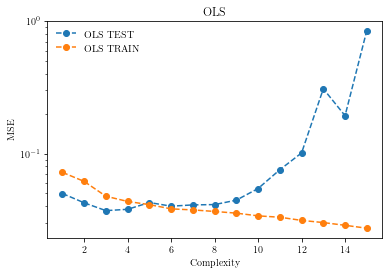

In [3]:
degrees = np.arange(1,max_degree+1)

plt.semilogy(degrees, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degrees, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)
plt.savefig(FIGPATH + "OLS_MSE_Bootstrap_Hastie_211_N_{n}.pdf")

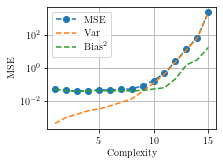

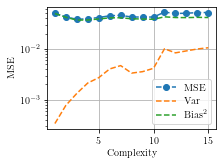

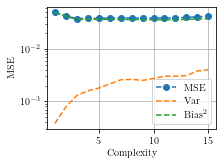

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ols_boot_variance,"--", label="Var")
plt.semilogy(degrees, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_OLS_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig(FIGPATH+f"Franke_Ridge_bootstrap_N_{n}.pdf")

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
#plt.ylim([1e-4, 2e-1])
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig(FIGPATH+f"Franke_LASSO_bootstrap_N_{n}.pdf")

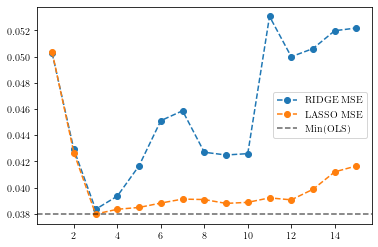

In [5]:
#plt.semilogy(degrees, ols_boot_mse,"o--",label="OLS MSE")
plt.plot(degrees, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.plot(degrees, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.axhline(np.min(lasso_best_lambda_boot_mse), color="black", alpha=0.6, ls="--", label="Min(OLS)")

plt.legend()

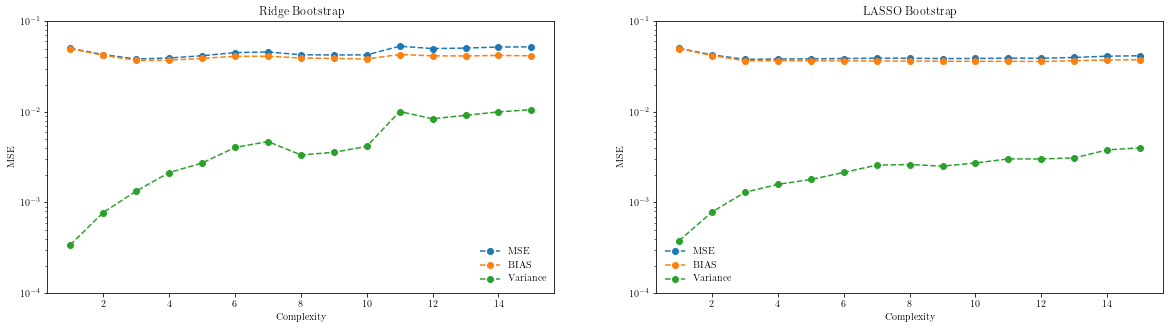

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degrees, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degrees, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degrees, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degrees, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

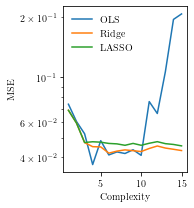

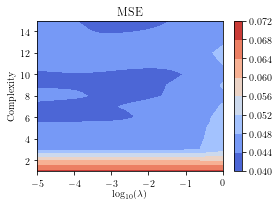

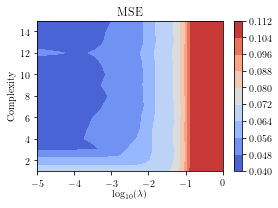

In [7]:
# CONTOUR PLOTS

plt.figure(figsize=FIGURESIZE*np.array([0.7, 1]))
#plt.axvline(degrees[np.argmin(ols_cv_mse)], ls="--", color="black", alpha=0.6)
plt.semilogy(degrees, ols_cv_mse, label="OLS")
plt.semilogy(degrees, best_ridge_mse, label="Ridge")
plt.semilogy(degrees, best_lasso_mse, label="LASSO")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig(FIGPATH + f"OLS_CV_Franke_N_{n}.pdf")

# RIDGE
plt.figure(figsize=(4, 3) * np.array([1,1]))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, ridge_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"RIDGE_CV_Franke_contour_N_{n}.pdf")

# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degrees)
plt.contourf(X, Y, lasso_lamb_deg_mse, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("MSE")
plt.tight_layout()
plt.savefig(FIGPATH + f"LASSO_CV_Franke_contour_N_{n}.pdf")

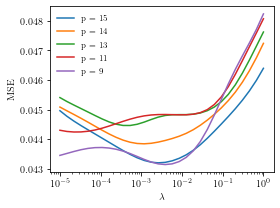

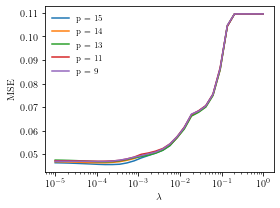

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"RIDGE_best_lambda_FRANKE_N_{n}.pdf")

# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')
plt.savefig(FIGPATH+f"LASSO_best_lambda_FRANKE_N_{n}.pdf")

In [9]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 1.00000000e+00 1.88739182e-02 1.74332882e-03
 1.17210230e-03 1.00000000e-05 3.29034456e-05 2.59294380e-03
 3.85662042e-03 1.26896100e-02 2.21221629e-05 5.29831691e-04
 5.29831691e-04 1.17210230e-03 2.59294380e-03]
[5.29831691e-04 1.17210230e-03 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00000000e-05 7.27895384e-05 1.08263673e-04
 1.08263673e-04 1.08263673e-04 1.08263673e-04 1.61026203e-04
 1.61026203e-04 1.61026203e-04 1.61026203e-04]


In [10]:
degree=7 # See how the best hyperparameters from CV-MSE above actually perform.
ridge_lambda= best_ridge_lambda[degree-1] # Ditto
lasso_lambda= best_lasso_lambda[degree-1] # Ditto
plot_grid_size=2000

np.random.seed(SEEDVAL)
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

# Setting up plotting grid
x_plot = np.linspace(0, 1, plot_grid_size)
y_plot = np.linspace(0, 1, plot_grid_size)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]

z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(plot_grid_size, -1)

# Ridge

betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(plot_grid_size, -1)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False, max_iter=10000).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(plot_grid_size, -1)


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42561012585265345, tolerance: 0.005478510025237233
  positive)


In [11]:
print(stat_tools.MSE(z_plot_franke,z_predict_ols))
print(stat_tools.MSE(z_plot_franke,z_predict_ridge))
print(stat_tools.MSE(z_plot_franke,z_predict_lasso))

0.004406057171071196
0.004528528796729239
0.006265485178794638


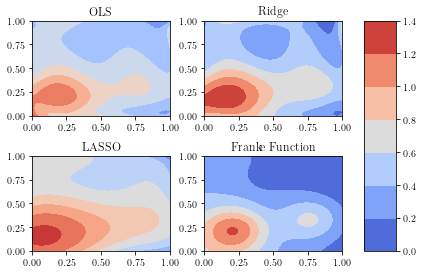

In [12]:
plt.subplot(221)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
plt.title("OLS")
plt.tight_layout()

plt.subplot(222)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
plt.title("Ridge")
plt.tight_layout()

plt.subplot(223)
plt.contourf(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
plt.title("LASSO")
plt.tight_layout()

plt.subplot(224)
plt.contourf(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)
plt.title("Franke Function")
plt.tight_layout()


plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

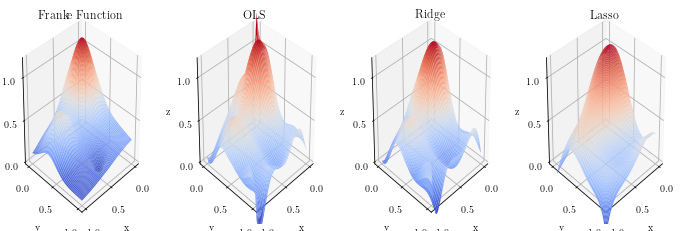

In [13]:
fig = plt.figure(figsize=(3 * 4,4))

# Plot the analytic curve
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])

surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
# Plot the Ridge
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
# Plot the Lasso
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim([0, 1.2])
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
